In [15]:
%matplotlib notebook
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

from scipy.stats.stats import pearsonr
from scipy import signal
from ipyparallel import Client
from ipyparallel import depend, require, dependent
from roipoly import roipoly
from scipy.ndimage import gaussian_filter
from sklearn.externals.joblib import Parallel, delayed, cpu_count
from sklearn.utils import gen_even_slices
import cv2


height = 256
width = 256
TRUE_FRAMERATE = 28.815

In [2]:
class Position:
    def __init__(self, row, col):
        self.row = row
        self.col = col

class Seed:
    # in mm
    def __init__(self, name, y, x):
        self.name = name
        self.y = y
        self.x = x
        
class ScaledSeed(Seed):
    def __init__(self, name, row, col, bregma):
        self.name = name
        self.row = row
        self.col = col
        self.signal = None
        self.bregma = bregma
        self.corr_map = None

# Load the frames
def get_raw_frames(filename, channel):
    with open(filename, "rb") as file:
        raw_frames = np.fromfile(file, dtype=np.uint8)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height*3)), height, width, 3))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :, channel]
    
def get_dark_frames(green_frames):
    threshold = 4
    green_frames = np.reshape(green_frames, (green_frames.shape[0], green_frames.shape[1]*green_frames.shape[2]))
    temporal_means = np.mean(green_frames, axis=1)
    start_index = 0
    end_index = 0
    for mean, i in zip(temporal_means, range(0, temporal_means.shape[0]-1)):
        if mean < threshold and i < 1000:
            start_index= i
        elif mean < threshold and i >= 1000:
            end_index = i
            break

            
    return (start_index, end_index)

def rotate_video(frames, k):
    for i in range(len(frames)):
        frames[i] = np.rot90(frames[i], k)
        
    return frames

old_seeds = [Seed("V1", -3, 2.5), Seed("OB", 4.4, .86), Seed("XX", -1.75, 3.5), 
             Seed("BC", -1, 3.5), Seed("HL", -.25, 2), Seed("FL", .25, 2), 
             Seed("M1", 1.75, 1.5), Seed("RS", -2.5, 1), Seed("AC", 0, 1), 
             Seed("M2", 2.75, 1.25), Seed("OR", .75, 3)]

# An array/list where bregma[0] is y and bregma[1] is x
# Gives you back a list of seeds, as per matthieu vanni matlab program.
#ppmm is pixels per mm. 256/10mm or so for hyperscanner :/
# Direction is one of 'u', 'd', 'l', 'r' Indicates the direction mouse is facing.
#Seed("V1", -3.2678, 2.5168)
def generate_seeds(bregma, ppmm, direction=None):
    # All the seeds
    #Seed("OB", 4.6, .86)
    seeds = [Seed("M1", 1.03+1, 1.365), 
             Seed("FL", .16, 2.47), Seed("HL", -.7, 1.85), Seed("aBC", -1.36+.575, 3.35), 
             Seed("pBC", -1.9, 3.35), Seed("AC", 0+1, 0.6),  Seed("RS", -2.8858+1, 0.62043),
             Seed("V1", -4.2678+.8, 2.5168), Seed("mPTA", -2.4962, 2.2932), Seed("lPTA", -2.4962-0.3, 3.35-0.2), Seed("Un", -1.5, 2.6)]
        
             

    
    
    
    ppmmed_seeds = []
    if direction == 'u' or direction == None:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
    elif direction == 'd':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
    elif direction == 'r':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.x), int(bregma.col+ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row+ppmm*seed.x), int(bregma.col+ppmm*seed.y), bregma))
    else:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.col+ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.col-ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
    return ppmmed_seeds
            

In [4]:
def get_processed_frames(filename, height, width):
    with open(filename, 'rb') as file:
        raw_frames = np.fromfile(file, dtype=np.float32)
        #raw_frames = raw_frames.byteswap(True)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
    return raw_frames


In [120]:
#AUTOMATIC EXPERIMENT SELECTOR
directory = "/media/gu4n1n3/Data2/2_mice/20180316/"
experiment = "Experiment_1/"


import os
from os.path import join, getsize
video_file = ''
timestamps_file = ''
subset_behaviour_file = ''
left_mouse_processed_file = ''
right_mouse_processed_file = ''
left_green_frame_file = ''
right_green_frame_file = ''
left_blue_frame_file = ''
right_blue_frame_file = ''
#LEGACY
combined_file = ''
for root, dirs, files in os.walk(directory+experiment):
    if "Behaviour" in root:
        for file in files:
            if 'timestamps' in file:
                timestamps_file = os.path.join(directory, experiment, root, file)
            elif 'subset' in file and 'raw' in file:
                subset_behaviour_file = os.path.join(directory, experiment, root, file)
            elif 'h264' in file:
                video_file = os.path.join(directory, experiment, root, file)
    else:
        for file in files:
            if '.mp4' not in file and 'png' not in file:
                if 'combined' in file and "raw" in file and 'upscaled' not in file:
                    if not 'gsr' in file:
                        if 'bandpass' in file:
                            combined_file = os.path.join(directory, experiment, root, file)
                elif 'LEFT_GREEN_processed' in file and '0.01-3.0Hz' in file:
                #elif 'LEFT_corrected_g_by_b' in file and '0.01-3.0Hz' in file:
                    left_mouse_processed_file = os.path.join(directory, experiment, root, file)
                #elif 'RIGHT_corrected_g_by_b' in file and '0.01-3.0Hz' in file:
                elif 'RIGHT_GREEN_processed' in file and '0.01-3.0Hz' in file:
                    right_mouse_processed_file = os.path.join(directory, experiment, root, file)
                elif 'LEFT_RAW_BLUE_FRAME' in file:
                    left_blue_frame_file = os.path.join(directory, experiment, root, file)
                elif 'RIGHT_RAW_BLUE_FRAME' in file:
                    right_blue_frame_file = os.path.join(directory, experiment, root, file)
                elif 'LEFT_RAW_GREEN_FRAME' in file:
                    left_green_frame_file = os.path.join(directory, experiment, root, file)
                elif 'RIGHT_RAW_GREEN_FRAME' in file:
                    right_green_frame_file = os.path.join(directory, experiment, root, file)
             
date = left_mouse_processed_file.split("/")[5]
title = left_mouse_processed_file.split('/')[-1].split('.raw')[0]

print(date)
print(timestamps_file)
print(video_file)
print(subset_behaviour_file)
print(combined_file)
print(left_mouse_processed_file)
print(right_mouse_processed_file)
print(left_blue_frame_file)
print(right_blue_frame_file)
print(left_green_frame_file)
print(right_green_frame_file)


20180316
/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/Behaviour/M902L_M903R_March-16_1444_experiment-1_wt_cage-mates_together_12mm_timestamps.raw
/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/Behaviour/M902L_M903R_March-16_1444_experiment-1_wt_cage-mates_together_12mm.h264
/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/Behaviour/M902L_M903R_March-16_1444_experiment-1_wt_cage-mates_together_12mm_subset_interpolated.raw

/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/LEFT_GREEN_processed__interp_dff0_bandpass0.01-3.0Hz_MM902L_March-16_1445_experiment-1_M903R_wt_cage-mates_together_12mm.raw
/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/RIGHT_GREEN_processed__interp_dff0_bandpass0.01-3.0Hz_MM903R_March-16_1445_experiment-1_M902L_wt_cage-mates_together_12mm.raw
/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/LEFT_RAW_BLUE_FRAME.npy
/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/RIGHT_RAW_BLUE_FRAME.npy
/media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/LEFT_RAW_GREEN_

In [27]:
def corr(pixel, seed_pixel):
    return pearsonr(pixel, seed_pixel)[0]

def generate_matrix_two_mice(left_mouse_green_frames, right_mouse_green_frames, left_seeds, right_seeds, radius=5):
    all_seeds=np.zeros((np.size(left_seeds)+np.size(right_seeds),np.shape(left_mouse_green_frames)[0]))
    the_labels = []
    the_positions = []
    cnt=0
    # FIX ME REVERSED ROW AND COL
    left_first_frame[left_seeds[0].bregma.row, left_seeds[0].bregma.col] = 255
    for seed in left_seeds:
        the_labels.append(seed.name+"-L")
        top = seed.row-radius
        bottom = seed.row+radius
        left = seed.col-radius
        right = seed.col+radius
        
        if top < 0:
            top = 0
        if bottom > 256:
            bottom = 256
        if left < 0:
            left = 0
        if right > 256:
            right = 256
        seed.signal = np.mean(np.mean(left_mouse_green_frames[:, top:bottom, left:right], axis=1), axis=1)
        all_seeds[cnt,:]=seed.signal
        cnt+=1
        left_first_frame[top:bottom, left:right] = 255
        the_positions.append((seed.row, seed.col))
        
    #left_mouse_green_frames[0, :, :].tofile("left.raw")
    # FIX ME REVERESED ROW AND COL
    right_first_frame[right_seeds[0].bregma.row, right_seeds[0].bregma.col] = 255      
    for seed in right_seeds:
        
        the_labels.append(seed.name+"-R")
        top = seed.row-radius
        bottom = seed.row+radius
        left = seed.col-radius
        right = seed.col+radius
        
        if top < 0:
            top = 0
        if bottom > 256:
            bottom = 256
        if left < 0:
            left = 0
        if right > 256:
            right = 256
        seed.signal = np.mean(np.mean(right_mouse_green_frames[:, top:bottom, left:right], axis=1), axis=1)

        right_first_frame[top:bottom, left:right] = 255
        all_seeds[cnt,:]=seed.signal
        cnt+=1
        
        the_positions.append((seed.row, seed.col))

    
    
    
    #right_mouse_green_frames[0, :, :].tofile("right.raw")
    
    
    # Calculate correlation coefficients
    corr_mat=np.corrcoef(all_seeds)

    fig = plt.figure(figsize=(10,11))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr_mat, interpolation='nearest', vmin=0, vmax=1, cmap='viridis')
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    ax.set_title(title+"\n", y=1.15)
    ax.set_xticks([i for i in range(np.size(left_seeds)+np.size(right_seeds))])
    ax.set_yticks([i for i in range(np.size(left_seeds)+np.size(right_seeds))])
    ax.set_xticklabels(the_labels, rotation='vertical')
    ax.set_yticklabels(the_labels)
    print(the_labels)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.imshow(left_first_frame, cmap='gray')
    
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    ax3.imshow(right_first_frame, cmap='gray')
    print("Saving matrices at: "+directory+experiment)
    fig.savefig(directory+experiment+title+"_TRUNCATED.svg")
    np.save(directory+experiment+title+"_TRUNCATED.npy", corr_mat)
    
    plt.show()


In [121]:
left_blue_frame = np.load(left_blue_frame_file)
right_blue_frame = np.load(right_blue_frame_file)

left_green_frame = np.load(left_green_frame_file)
right_green_frame = np.load(right_green_frame_file)

In [122]:
# Separated mice loading
left_mouse_frames = get_processed_frames(left_mouse_processed_file, 256, 256)
left_mouse_frames[np.where(left_mouse_frames == -np.inf)] = -1

right_mouse_frames = get_processed_frames(right_mouse_processed_file, 256, 256)
right_mouse_frames[np.where(right_mouse_frames==-np.inf)] = -1

(10084, 256, 256)
(10084, 256, 256)


<IPython.core.display.Javascript object>


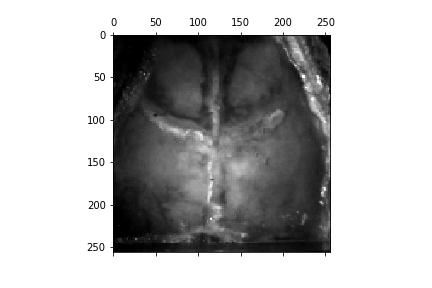

In [116]:
#Left Bregma selection
fig, ax = plt.subplots()
ax.matshow(left_blue_frame, cmap='gray')
#ax.matshow(left_mouse_frames[100], cmap='viridis', vmin=0, vmax=0.2)
left_collector = []
def onclick(event):
    left_collector.append(Position(int(event.ydata), int(event.xdata)))
    
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


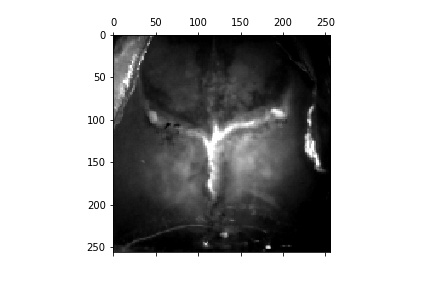

In [117]:
#Right Bregma selection
fig, ax = plt.subplots()
ax.matshow(right_blue_frame, cmap='gray')
#ax.matshow(right_mouse_frames[100], cmap='viridis', vmin=0, vmax=0.2)

right_collector = []
def onclick(event):
    right_collector.append(Position(int(event.ydata), int(event.xdata)))
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [118]:
left_bregma = left_collector[-1]
right_bregma = right_collector[-1]
print(left_bregma.col, left_bregma.row)
print(right_bregma.col, right_bregma.row)

121 115
121 105


(22,)
(22,)


<IPython.core.display.Javascript object>


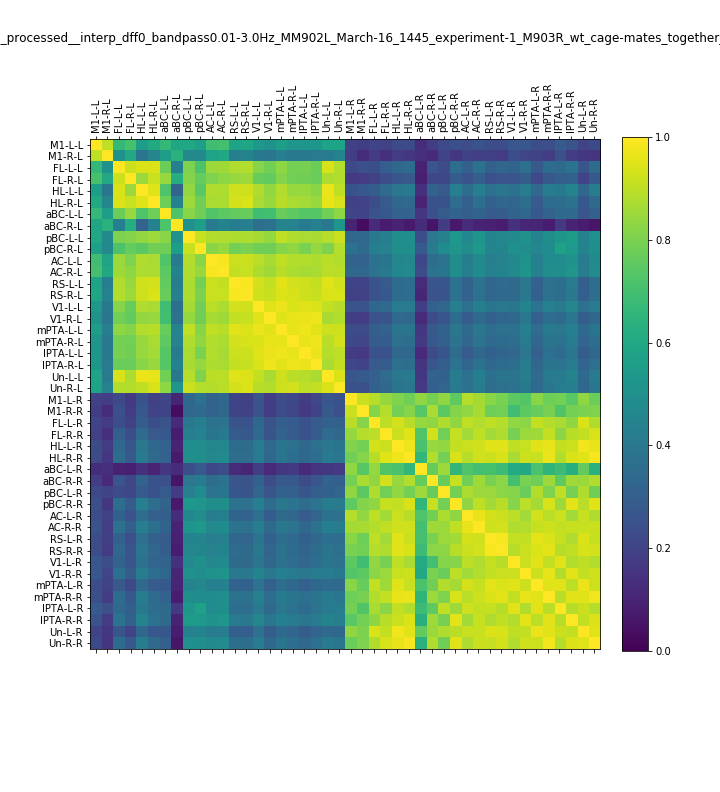

['M1-L-L', 'M1-R-L', 'FL-L-L', 'FL-R-L', 'HL-L-L', 'HL-R-L', 'aBC-L-L', 'aBC-R-L', 'pBC-L-L', 'pBC-R-L', 'AC-L-L', 'AC-R-L', 'RS-L-L', 'RS-R-L', 'V1-L-L', 'V1-R-L', 'mPTA-L-L', 'mPTA-R-L', 'lPTA-L-L', 'lPTA-R-L', 'Un-L-L', 'Un-R-L', 'M1-L-R', 'M1-R-R', 'FL-L-R', 'FL-R-R', 'HL-L-R', 'HL-R-R', 'aBC-L-R', 'aBC-R-R', 'pBC-L-R', 'pBC-R-R', 'AC-L-R', 'AC-R-R', 'RS-L-R', 'RS-R-R', 'V1-L-R', 'V1-R-R', 'mPTA-L-R', 'mPTA-R-R', 'lPTA-L-R', 'lPTA-R-R', 'Un-L-R', 'Un-R-R']


<IPython.core.display.Javascript object>


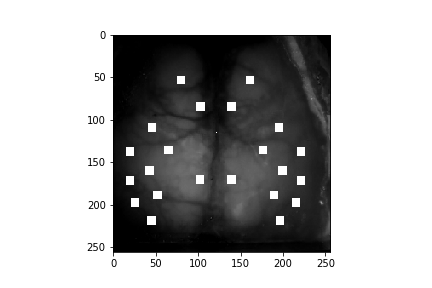

<IPython.core.display.Javascript object>


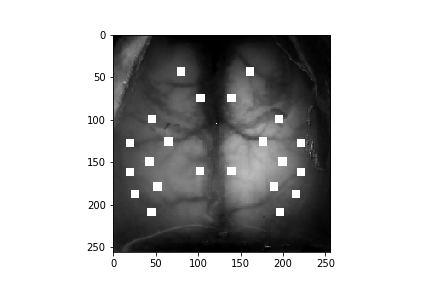

Saving matrices at: /media/gu4n1n3/Data2/2_mice/20180316/Experiment_1/


In [123]:
# From imagej first number is y and second number is x
# left_bregma = Position(110,125)
# right_bregma = Position(152,130)

start_interaction_frame = 2872
end_interaction_frame = 6930
# left_ppmm = 26
# right_ppmm = 25.5

#left_bregma = Position(97,128)
#right_bregma = Position(152,130)
#right_bregma = Position(147,139)

left_ppmm = 30
right_ppmm = 30

# left_bregma = Position(93,132)
# right_bregma = Position(158,133)

# left_ppmm = 26.5
# right_ppmm = 22.88


left_first_frame = np.copy(left_green_frame)
right_first_frame = np.copy(right_green_frame)


#Generate seeds
# generate_seeds(bregma, ppmm, direction=None):
left_seeds = generate_seeds(left_bregma, left_ppmm, direction='u')
right_seeds = generate_seeds(right_bregma, right_ppmm, direction='u')
print(np.shape(left_seeds))
print(np.shape(right_seeds))
matrix = generate_matrix_two_mice(left_mouse_frames[start_interaction_frame:end_interaction_frame],\
                                  right_mouse_frames[start_interaction_frame:end_interaction_frame], left_seeds, right_seeds)